# Image Compression and the FFT2

In [4]:
pip install opencv-contrib-python

  Obtaining dependency information for opencv-contrib-python from https://files.pythonhosted.org/packages/f3/78/b504ca8f7a312918d184e0b8093c62bc9a110d8154f658b591ef5c020d65/opencv_contrib_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 MB 30.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
from matplotlib.image    import imread
import numpy             as np
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 16})

Auxiliar functions


Load image and transform to gray scale by averaging over channels (work on one array)

In [9]:
#path= "/content/drive/MyDrive/Colab Notebooks/sandbox/"

images = ['Luna.jpeg','butterfly.jpg','cohort_2025.jpeg']

image = imread(images[0])
Ipx   = np.mean(image, -1).astype(np.float32)

print(f"Image shape: {Ipx.shape}")

Image shape: (768, 1024)


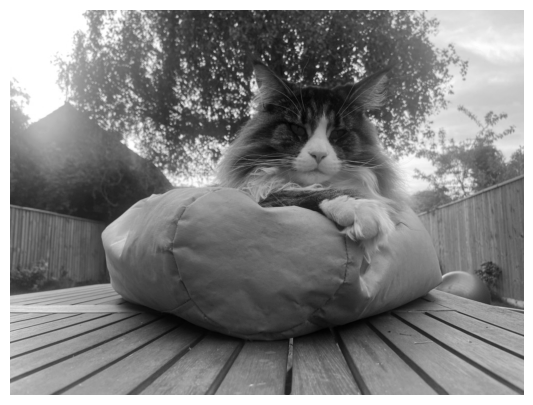

In [10]:
# Visualise image
plt.figure()
plt.imshow(Ipx,cmap='gray')
plt.axis('off')
plt.show()

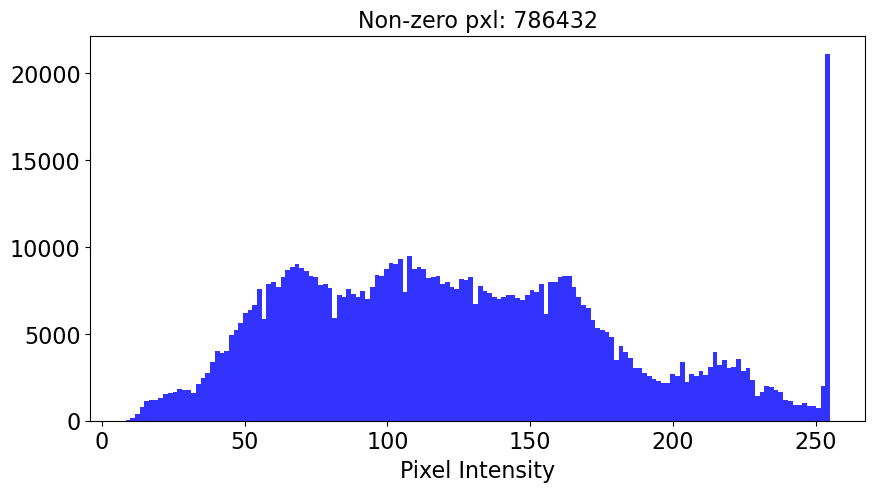

In [14]:
# Plot pixel magnitude histogram

non_zero_pxl = np.sum(Ipx!=0) # count non-zero pixels

fig, axs = plt.subplots(figsize=(10, 5))
plt.hist(Ipx.reshape(-1)  , bins=150, color='blue', alpha=0.8)
plt.title(f"Non-zero pxl: {non_zero_pxl}",fontsize=16)
plt.xlabel("Pixel Intensity")
plt.show()

## Apply FFT2

How does the FT look like?

In [16]:
# Compute the 2D Fast Fourier Transform of the input image
Ifft = np.fft.fft2(Ipx)

Iftsort = np.sort(np.abs(Ifft)) # sort by magnitude

# Shift the zero frequency component to the center of the spectrum
fft_shifted = np.fft.fftshift(Ifft)

# Compute the magnitude spectrum of the shifted FFT
magnitude_spectrum = np.abs(fft_shifted)

# Apply logarithmic scaling to enhance visualization of smaller frequencies
log_magnitude = np.log(1 + magnitude_spectrum)  # Add 1 to avoid log(0)

# Normalize the log-magnitude image to 0–255 range for better contrast
log_magnitude = cv2.normalize(log_magnitude, None, 0, 255, cv2.NORM_MINMAX)

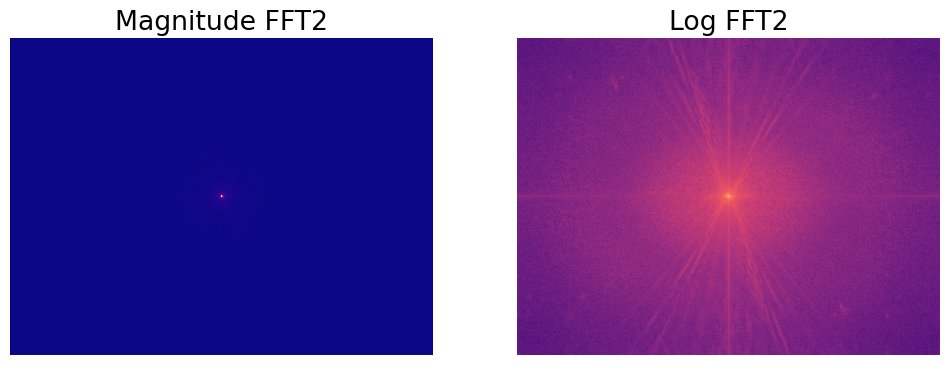

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Display the raw magnitude spectrum with a capped upper value for contrast
axs[0].imshow(magnitude_spectrum , cmap="plasma",
              norm=plt.Normalize(vmin=0, vmax=np.max(magnitude_spectrum) * 0.1))
axs[0].set_title("Magnitude FFT2")
axs[0].axis("off")

# Display the log-scaled, contrast-enhanced magnitude spectrum
axs[1].imshow(log_magnitude, cmap="magma")
axs[1].set_title("Log FFT2")
axs[1].axis("off")

plt.show()


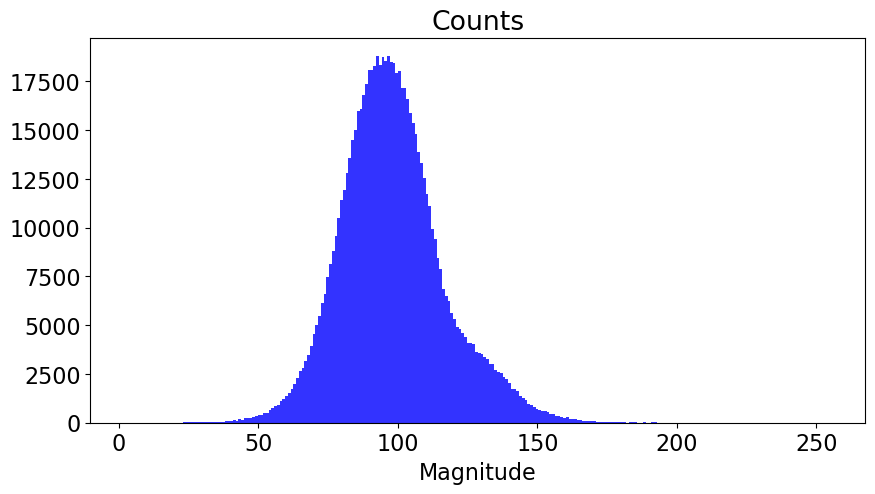

In [20]:
# Plot a histogram with non-zero FTT2 coefficients (log scale)
fig, axs = plt.subplots(figsize=(10, 5))
plt.hist(log_magnitude[log_magnitude>1],bins=256,color='blue', alpha=0.8)
plt.title("Counts")
plt.xlabel("Magnitude")
plt.show()

Keep the largers 10%, 5%, 1% and 0.2%  Fourier coefficients and truncate below

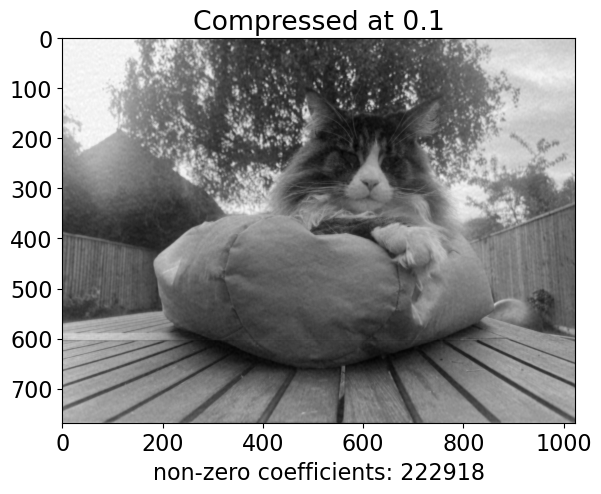

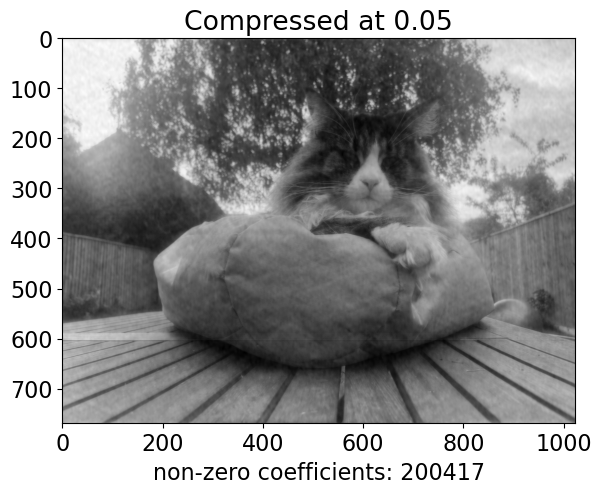

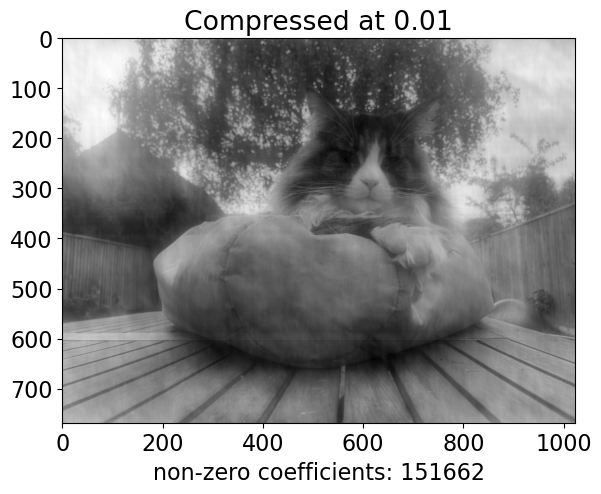

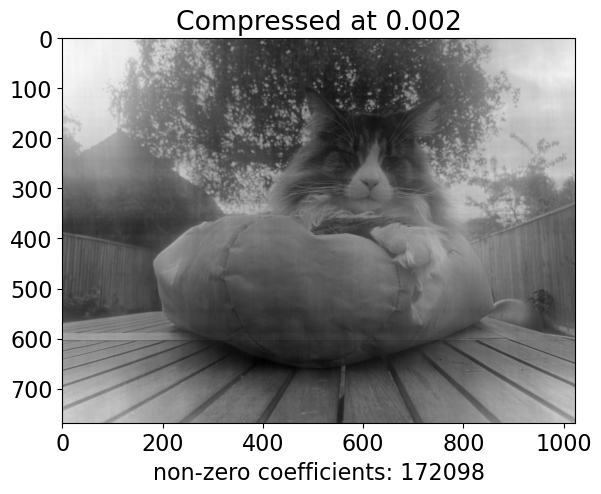

In [29]:
# Hard thresholding frequencies
for keep in (0.1, 0.05, 0.01, 0.002):
    # Threshold magnitude below which Fourier coefficients are considered negligible
    # Iftsort is  a sorted array of magnitudes of the Fourier coefficients
    thresh = Iftsort[int(np.floor((1 - keep) * len(Iftsort)))]
    thresh = Iftsort[int(np.floor((1-keep)*len(Iftsort)))]

    magnitude = np.abs(Ifft)
    ind = magnitude >thresh          # Mask of 0's and 1's to find small indices

    # Get rid of small indices
    Iftlow = Ifft*ind
    non_zero_coef = np.count_nonzero(Iftlow)

    # Inverse FTT2 to recover images with thereshold values (compressed image)
    ImageTH = np.fft.ifft2(Iftlow)
    ImageTH = np.abs(ImageTH)

    plt.figure()
    plt.imshow(ImageTH,cmap='gray')
    plt.title('Compressed at ' + str(keep))
    plt.xlabel(f'non-zero coefficients: {non_zero_coef}')


# Image Compression and the WT

In [30]:
# We need to install Pywavelts (https://pywavelets.readthedocs.io/en/latest/install.html)

# In Colab:
!pip install PyWavelets

# Locally:
# conda install pywavelets
# or
# pip install PyWavelets

import pywt
import cv2

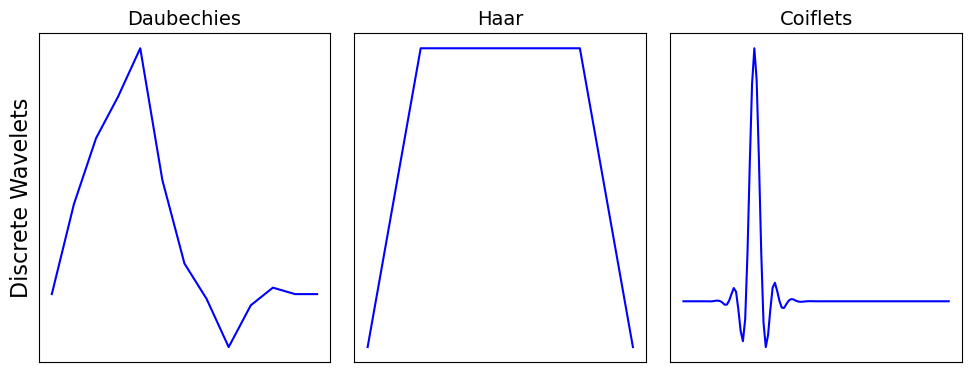

In [31]:
# List of discrete wavelets to visualize
discrete_wavelets = ['db2', 'haar', 'coif5']

fig, axarr = plt.subplots(nrows=1, ncols=len(discrete_wavelets), figsize=(10, 4))
for col_idx, wavelet_name in enumerate(discrete_wavelets):
    wavelet = pywt.Wavelet(wavelet_name)
    wavelet_function, x_values = wavelet.wavefun(level=2)[0], wavelet.wavefun(level=2)[-1]
    ax = axarr[col_idx]
    ax.plot(x_values, wavelet_function, color='Blue')
    ax.set_title(wavelet.family_name, fontsize=14)
    ax.set_yticks([])
    ax.set_xticks([])
    if col_idx == 0:
        ax.set_ylabel("Discrete Wavelets", fontsize=16)
plt.tight_layout()
plt.show()

Wavelet decomposition

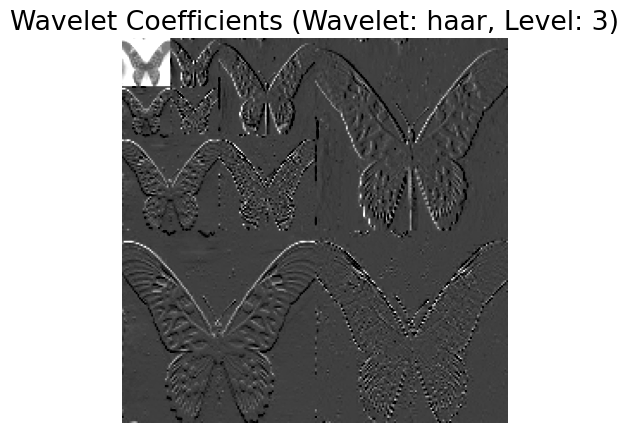

In [37]:
image = imread( images[1])
Ipx   = np.mean(image, -1).astype(np.float32)
# Define DWT parameters
n = 3  # Decomposition level
w = ['db2', 'haar', 'coif5']

# Apply 2D Discrete Wavelet Decomposition using PyWavelets
coeffs2 = pywt.wavedec2( Ipx, wavelet=w[1] , level=n )

# NormalisNormalize the approximation coefficients (low-frequency component)
# Helps in visualizing all coefficients on a similar scale
coeffs2[0] /= np.abs(coeffs2[0]).max()

# NormalisNormalize each set of detail coefficients at each level (horizontal, vertical, diagonal)
# containing high-frequency details in the image (edges, textures, etc.)
for detail_level in range(n):
    coeffs2[detail_level + 1] = [
        d / np.abs(d).max() for d in coeffs2[detail_level + 1]
    ]

# Convert the list of wavelet coefficients into a single 2D array for display
# Get approximation and detail coefficients
arr, coeff_slices = pywt.coeffs_to_array(coeffs2 )

# Display the combined wavelet coefficients
# Use grayscale colormap with specified contrast limits
plt.imshow(arr , cmap='gray', vmin=-0.25, vmax=0.75)
plt.title(f'Wavelet Coefficients (Wavelet: {w[1]}, Level: {n})')
plt.axis('off')
plt.show()


Keep the largers 10%, 5%, 1% and 0.2%  wavelet coefficients and truncate below

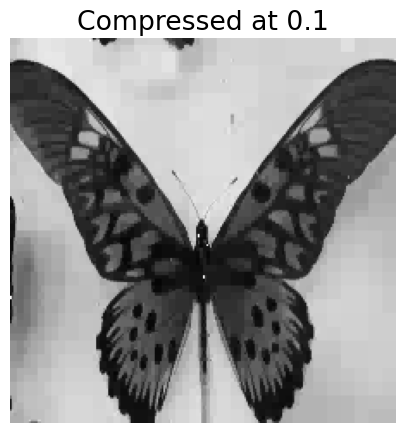

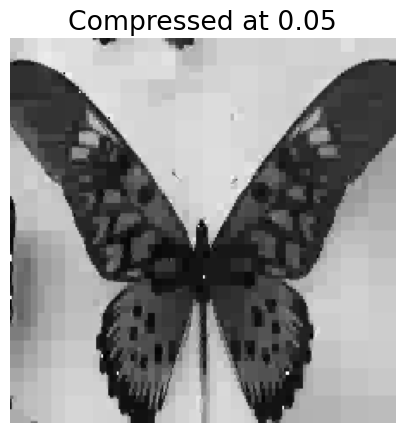

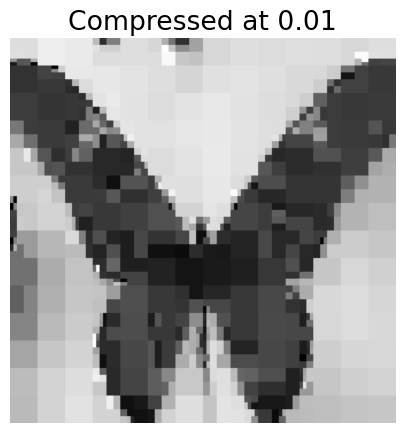

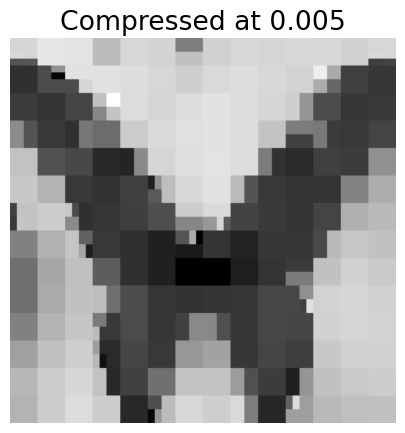

In [41]:
## Wavelet Compression
n = 4
w = 'db1'

coeffs = pywt.wavedec2(Ipx ,wavelet=w ,level=n )
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs )

Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

for keep in (0.1, 0.05, 0.01, 0.005):

    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind # Threshold small indices

    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec2')

    # Plot reconstruction
    Arecon = pywt.waverec2(coeffs_filt,wavelet=w)
    plt.figure()
    plt.imshow(Arecon.astype('uint8'),cmap='gray')
    plt.axis('off')
    plt.title('Compressed at ' + str(keep))


# Denoising  with FFT2 and TV

In [42]:
# Load or prepare grayscale image
image = Ipx.astype(np.float32)  # Assuming Ipx is already grayscale and float32

# Add Gaussian noise sigma[ 20, 30, 50]
sigma_noise = 50 
noise = image + sigma_noise + np.random.randn(*image.shape)
noise = np.clip(noise, 0, 255).astype(np.uint8)

In [43]:
# Compute FFT of the noisy image
noise_ft = np.fft.fft2(noise)                              # 2D Fast Fourier Transform of the noisy image
ftshift = np.fft.fftshift(noise_ft)                               # Shift the zero-frequency component to the center
F = np.log(np.abs(ftshift) + 1)          # Log of magnitude spectrum for better visualization

# Create a Gaussian Low-Pass Filter in the frequency domain
nx, ny = image.shape                     # Get the dimensions of the image
x = np.linspace(-ny / 2, ny / 2, ny)     # X-axis coordinates centered around zero
y = np.linspace(-nx / 2, nx / 2, nx)     # Y-axis coordinates centered around zero
X, Y = np.meshgrid(x, y)                 # Coordinate grid
R2 = X**2 + Y**2                         # Compute radious (squared distance from the centre)

sigma = 50                                      # STD controls  smoothing (larger = smoother) sigma[ 30,50]
gaussian_filter = np.exp(-R2 / (2 * sigma**2))  # Gaussian acting as low-pass filter

# Apply the filter in frequency domain
ftshift_filtered = ftshift * gaussian_filter     # Deconvolution is a multiplicaiton in the frequency domain
Ffilt = np.log(np.abs(ftshift_filtered) + 1)     # Log scale of filtered spectrum for visualization

# Inverse FFT to recover the filtered image in the pixel domain
FTfilt = np.fft.ifftshift(ftshift_filtered)           # Shift the zero-frequency component back
RFTfilt = np.fft.ifft2(FTfilt).real          # Inverse FFT and take real part
image_filt = np.clip(RFTfilt, 0, 255).astype(np.uint8)  # Clip to valid intensity range


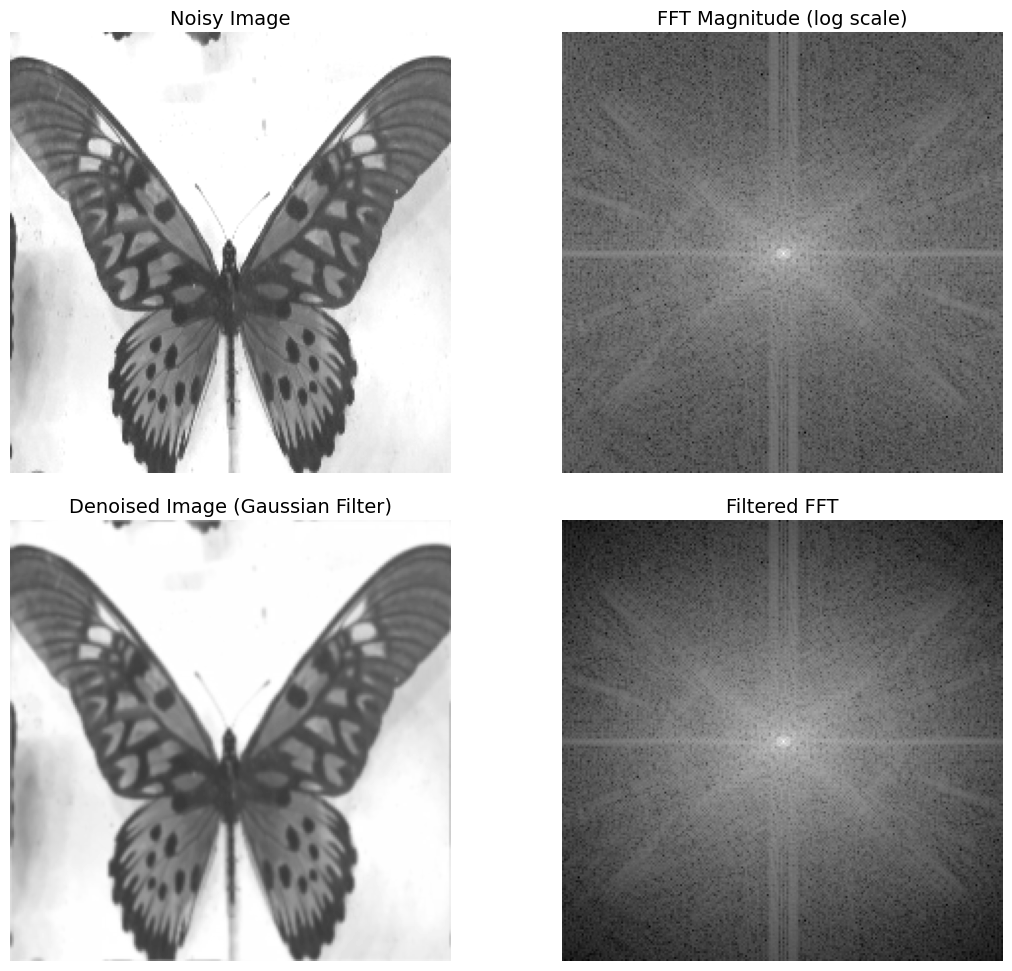

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top-left: Original noisy image
axs[0, 0].imshow(noise, cmap='gray', vmin=0, vmax=255)
axs[0, 0].set_title('Noisy Image', fontsize=14)
axs[0, 0].axis('off')

# Top-right: Log of magnitude of original FFT
axs[0, 1].imshow(F, cmap='gray')
axs[0, 1].set_title('FFT Magnitude (log scale)', fontsize=14)
axs[0, 1].axis('off')

# Bottom-left: Reconstructed image after filtering
axs[1, 0].imshow(image_filt, cmap='gray', vmin=0, vmax=255)
axs[1, 0].set_title('Denoised Image (Gaussian Filter)', fontsize=14)
axs[1, 0].axis('off')

# Bottom-right: Log of magnitude of filtered FFT
axs[1, 1].imshow(Ffilt, cmap='gray')
axs[1, 1].set_title('Filtered FFT', fontsize=14)
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

###  Total Variation (TV) Denoising:

### In the next exercise, you will test TV regularisation to denoise an image using different values of $\lambda=[0.01,0.05,0.1,0.15]$.

Recall that **TV denoising** problem is typically formulated as the following variational optimization:

$$
\min_u \left\{ \frac{1}{2} \| u - f \|_2^2 + \lambda \, \mathrm{TV}(u) \right\}
$$

where:

* $f$: the observed noisy image
* $u$: the denoised image (to be estimated)
* $\lambda > 0$: regularization parameter controlling the trade-off between data fidelity and smoothness
* $\mathrm{TV}(u)$: the **total variation** of the image $u$


#### Total Variation regularizer

The total variation term, $\mathrm{TV}(u)$, measures the ** gradient magnitude**, defined (in the **discrete** setting):
$$
\mathrm{TV}(u) = \sum_{i,j} \sqrt{ \left( u_{i+1,j} - u_{i,j} \right)^2 + \left( u_{i,j+1} - u_{i,j} \right)^2 }
$$


* Where the first term $\frac{1}{2} \| u - f \|_2^2$ drives the denoising term by making the image close to the noisy input.

* $\lambda \, \mathrm{TV}(u)$ promotes **piecewise smoothness**, preserving edges and reducing noise.


**Questions**:
* Whych value of $\lambda$ produces better denoising results?
* Does TV outperform the above denoising methods? why?


In [48]:
from skimage.restoration import denoise_tv_chambolle

## Denoising using Total Variation (TV)
lbd = 0.1  # Regularization parameter: controls the strength of TV denoising

# Apply TV denoising (preserves edges while removing noise)
Ftv = denoise_tv_chambolle(noise, weight=lbd)

# Compute 2D FFT of the TV-denoised image
FTtv = np.fft.fft2(Ftv)

# Shift zero-frequency component to center for visualization
FTtvshift = np.fft.fftshift(FTtv)

# Compute log-scaled FFT magnitude (for better visualization)
Ffilt = np.log(np.abs(FTtvshift) + 1)

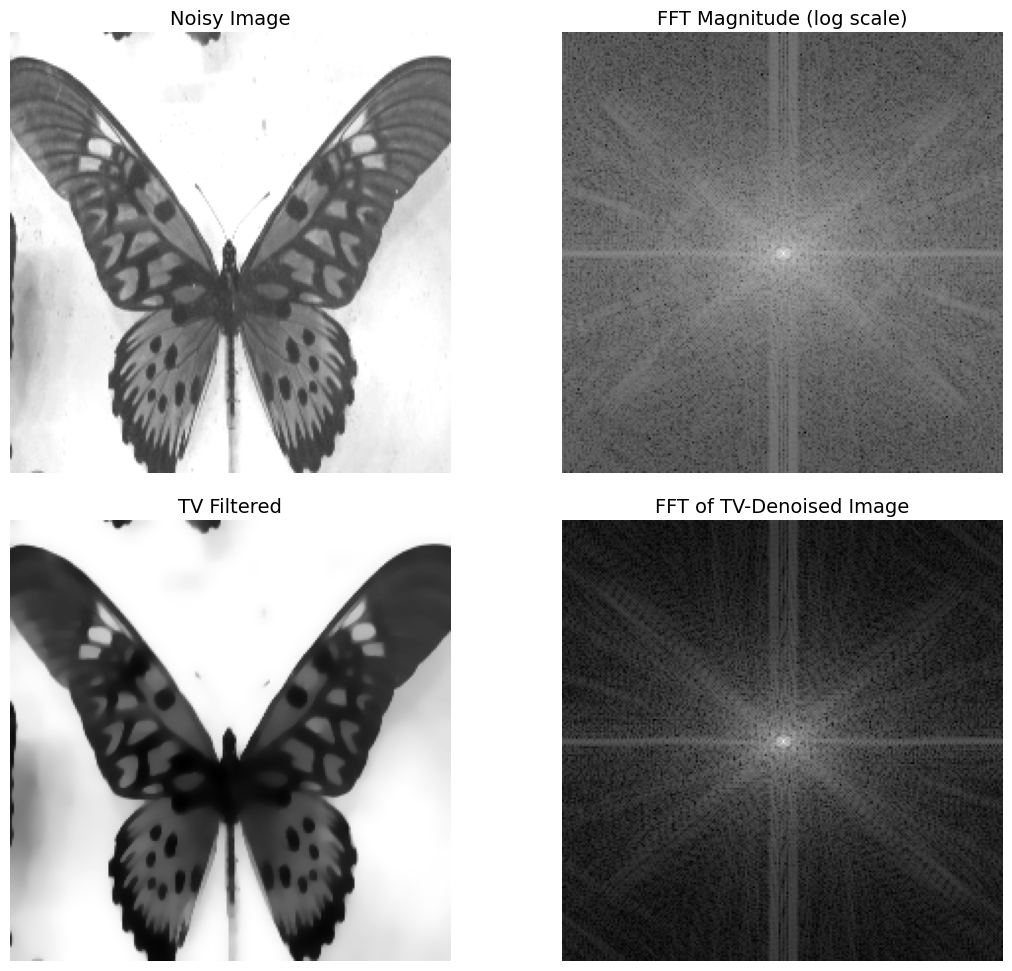

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Original noisy image
axs[0, 0].imshow(noise, cmap='gray', vmin=0, vmax=255)
axs[0, 0].set_title('Noisy Image', fontsize=14)
axs[0, 0].axis('off')

# FFT of noisy image
axs[0, 1].imshow(F, cmap='gray')
axs[0, 1].set_title('FFT Magnitude (log scale)', fontsize=14)
axs[0, 1].axis('off')

# TV-denoised image
axs[1, 0].imshow(Ftv, cmap='gray')
axs[1, 0].set_title('TV Filtered', fontsize=14)
axs[1, 0].axis('off')

#  FFT of the TV-denoised image
axs[1, 1].imshow(Ffilt, cmap='gray')
axs[1, 1].set_title('FFT of TV-Denoised Image', fontsize=14)
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

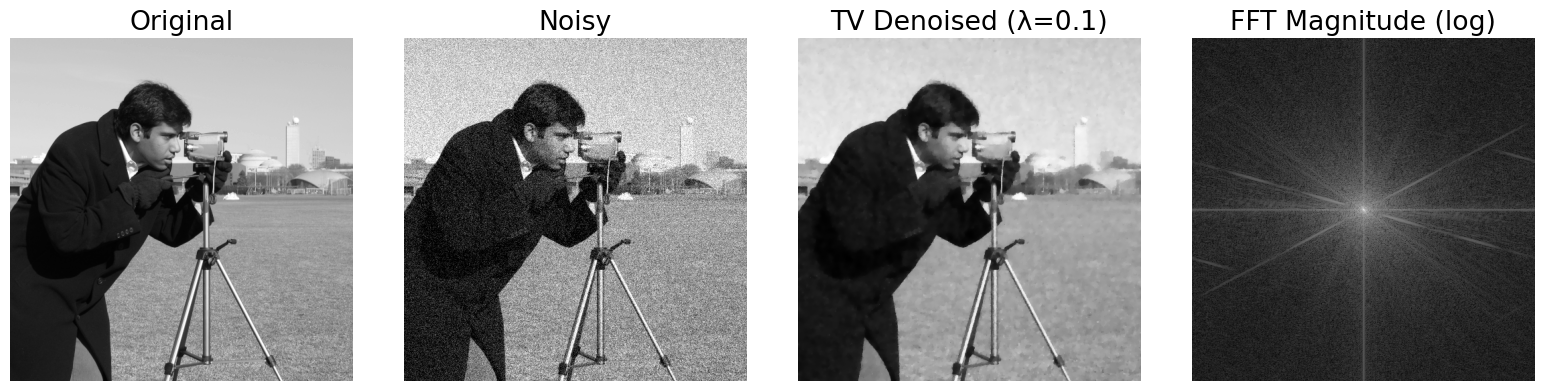

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.restoration import denoise_tv_chambolle
from skimage.util import random_noise
from numpy.fft import fft2, fftshift

# Load a sample image and convert to float
original_image = img_as_float(data.camera())

# Add Gaussian noise to the image
noisy_image = random_noise(original_image, mode='gaussian', var=0.01)

# Choose TV regularization parameter (try different values: 0.01, 0.05, 0.1, 0.5)
lbd = 0.1

# Apply Total Variation denoising
Ftv = denoise_tv_chambolle(noisy_image, weight=lbd)

# Compute 2D FFT of the denoised image
FTtv = fft2(Ftv)

# Shift zero-frequency component to center
FTtvshift = fftshift(FTtv)

# Compute log-scaled FFT magnitude for visualization
Ffilt = np.log(np.abs(FTtvshift) + 1)

# Plot results
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(noisy_image, cmap='gray')
ax[1].set_title("Noisy")
ax[1].axis('off')

ax[2].imshow(Ftv, cmap='gray')
ax[2].set_title(f"TV Denoised (λ={lbd})")
ax[2].axis('off')

ax[3].imshow(Ffilt, cmap='gray')
ax[3].set_title("FFT Magnitude (log)")
ax[3].axis('off')

plt.tight_layout()
plt.show()
